White Helmets
<h2>Prepare data</h2>

To get a better understanding of our data you asked us to create 3 new datasets from the original ones by randomizing certain features. This technique is called Null Models, we've talked about it for P3, and it was talked about in the paper "The structure and function of antagonistic ties in village social networks" by Amir Ghasemian and Nicholas A. Christakis.
The Null Models are to identify what properties of the real network are significant and not due to hazard. Since the null models are generated by randomizing a feature but keeping the rest intact, some properties of the original dataset might disapear. So these are the significant properties that will help us understand what are the rules of our real network(hence, not an organic network but one constructeed by the propaganda machine of the WH).

<h2>Extract network </h2>
  
So for both twitter and facebook datasets, we now have 4 datasets. From these we extract the same type of graph that for the first assignement, nodes are users and there is an edge present is they interacted on the same video with a time interval of less than 52 seconds. Here we have a tuning parameter for the network, the time delta we're using. This 52 seconds rule suppose it's less than the time a human needs to see that there is a new post, whatch the video, and THEN also interact with it. So 52s is a good threshold to detect bot activities, that would automatically repost the video for instance. 
But if we're facing human coordinated activities, maybe that this threshold is too short to detect all the potential activity. If we increase it, we face the risk of including real human interaction. So there is a trade off here that can be used for the analysis. 

Twitter network density with 52s rule : 0.000021
Facebook network density with 52s rule : 0.000651

Both seems to me really low.

<h2>Compare networks</h2>

To compare these networks I will use different metrics:
- number of edges : here indicates how synchronised the actions are
- clustering coefficient : Measures how likely it is that two neighbors of a node are also connected. Coordinated campaigns often form tightly connected groups that amplify similar narratives. Random networks usually have low clustering, so higher values indicate non-random coordination. 
- modularity : Quantifies the presence of distinct communities within the network. Influence operations typically involve groups of accounts promoting similar messages. High modularity compared to a random baseline suggests organized, topic-based coordination.
- 



In [10]:
import pandas as pd
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt
import community as community_louvain

def extract_network(df, time_threshold=180):

    G = nx.Graph()
    all_users = df['nodeUserID'].unique()
    G.add_nodes_from(all_users)
    df['nodeTime'] = pd.to_datetime(df['nodeTime'])
    grouped = df.groupby('videoID')
    edge_list = []
    
    for video_id, group in grouped:
        if len(group) < 2:
            continue
            
        group = group.sort_values('nodeTime')
        
        users = group['nodeUserID'].tolist()
        times = group['nodeTime'].tolist()
        n = len(users)

        for i in range(n):
            for j in range(i + 1, n):
                delta = (times[j] - times[i]).total_seconds()
                if delta <= time_threshold:
                    if users[i] != users[j]:
                        edge_list.append((users[i], users[j]))
                else:
                    break
    G.add_edges_from(edge_list)
    return G

def plot_network_overview(G, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    pos_spring = nx.spring_layout(G, seed=42)
    nx.draw(G, pos_spring, ax=axes[0], node_size=20, node_color='blue', 
            edge_color='gray', alpha=0.7)
    axes[0].set_title(f"{title}\n(Spring Layout)")
    axes[0].axis('off')
    
    pos_circular = nx.circular_layout(G)
    nx.draw(G, pos_circular, ax=axes[1], node_size=20, node_color='blue', 
            edge_color='gray', alpha=0.7)
    axes[1].set_title(f"{title}\n(Circular Layout)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

import numpy as np

def analyze_network_metrics(G, name="Réseau"):
    
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Gestion des graphes vides
    if num_edges == 0:
        return {
            "Network": name,
            "Nodes": num_nodes,
            "Edges": 0,
            "Density": 0.0,
            "Clustering Coeff": 0.0,
            "Modularity": 0.0,
            "Communities": 0,
            "Avg Betweenness": 0.0,
            "Max Betweenness": 0.0
        }

    # Densité
    density = nx.density(G)

    # Clustering
    avg_clustering = nx.average_clustering(G)
    
    # Modularité (Louvain)
    try:
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
        num_communities = len(set(partition.values()))
    except ValueError:
        modularity = 0.0
        num_communities = 0

    # Betweenness Centrality
    bet_centrality = nx.betweenness_centrality(G, weight=None, normalized=True)
    
    # On extrait la moyenne et le max (le noeud le plus central)
    avg_betweenness = np.mean(list(bet_centrality.values()))
    max_betweenness = max(bet_centrality.values())

    return {
        "Network": name,
        "Nodes": num_nodes,
        "Edges": num_edges,
        "Density": round(density, 6),
        "Clustering Coeff": round(avg_clustering, 4),
        "Modularity": round(modularity, 4),
        "Communities": num_communities,
        "Avg Betweenness": round(avg_betweenness, 5),
        "Max Betweenness": round(max_betweenness, 5)
    }

if __name__ == "__main__":
   
    print("Chargement des données...")
    
    df_twitter = pd.read_csv('original_data/twitter_cross_platform.csv', sep=',') 
    df_twitter_time = pd.read_csv('data/twitter/random_time.csv', sep=',')
    df_twitter_video = pd.read_csv('data/twitter/random_video.csv', sep=',')
    df_twitter_time_video = pd.read_csv('data/twitter/random_video&time.csv', sep=',')
    
    G_twitter = extract_network(df_twitter)
    G_twitter_time = extract_network(df_twitter_time)
    G_twitter_video = extract_network(df_twitter_video)
    G_twitter_time_video = extract_network(df_twitter_time_video)

    twitter_networks = {
        "Original": G_twitter,
        "Random Time": G_twitter_time,
        "Random Video": G_twitter_video,
        "Random Time & Video": G_twitter_time_video
    }

    df_facebook = pd.read_csv('original_data/facebook_cross_platform.csv', sep=',')
    df_facebook_time = pd.read_csv('data/facebook/random_time.csv', sep=',')
    df_facebook_video = pd.read_csv('data/facebook/random_video.csv', sep=',')
    df_facebook_time_video = pd.read_csv('data/facebook/random_video&time.csv', sep=',')

    G_facebook = extract_network(df_facebook)
    G_facebook_time = extract_network(df_facebook_time)
    G_facebook_video = extract_network(df_facebook_video)
    G_facebook_time_video = extract_network(df_facebook_time_video)

    facebook_networks = {
        "Original": G_facebook,
        "Random Time": G_facebook_time,
        "Random Video": G_facebook_video,
        "Random Time & Video": G_facebook_time_video
    }
    
    allmetrics = []
    
    for name, G in twitter_networks.items():
        #print(f"Twitter network {name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        # plot_network_overview(G, f"Twitter Network - {name}")
        allmetrics.append(analyze_network_metrics(G, name=f"Twitter - {name}"))

    for name, G in facebook_networks.items():
        #print(f"Facebook network {name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        # plot_network_overview(G, f"Facebook Network - {name}")
        allmetrics.append(analyze_network_metrics(G, name=f"Facebook - {name}"))

    df_metrics = pd.DataFrame(allmetrics)
    columns_order = ["Network", "Nodes", "Edges", "Modularity", "Clustering Coeff", "Communities", "Density", "Avg Betweenness", "Max Betweenness"]
    df_metrics = df_metrics[columns_order]
    
    print(df_metrics.to_string(index=False))



Chargement des données...
                       Network  Nodes  Edges  Modularity  Clustering Coeff  Communities  Density  Avg Betweenness  Max Betweenness
            Twitter - Original   4947    805      0.9839            0.0359         4259 0.000066          0.00000          0.00010
         Twitter - Random Time   4947    235      0.9287            0.0072         4747 0.000019          0.00000          0.00015
        Twitter - Random Video   4947    219      0.9799            0.0026         4734 0.000018          0.00000          0.00002
 Twitter - Random Time & Video   4947    738      0.7772            0.0307         4418 0.000060          0.00000          0.00586
           Facebook - Original    684    294      0.9117            0.1376          540 0.001259          0.00001          0.00089
        Facebook - Random Time    684     11      0.8595            0.0044          674 0.000047          0.00000          0.00000
       Facebook - Random Video    684     11      0.8595 

<h2>Results</h2>

With 52 seconds threshold (bot activity):

| Network                        | Nodes | Edges | Modularity | Clustering Coeff | Communities   | Density  | Avg Betweenness | Max Betweenness |
|--------------------------------|-------|-------|------------|------------------|---------------|----------|-----------------|-----------------|
| Twitter - Original             | 4947  | 253   | 0.9895     | 0.0042           | 4702 0.000021 | 0.000021 | 0.0             | 0.00000         |
| Twitter - Random Time          | 4947  | 93    | 0.9529     | 0.0021           | 4858 0.000008 | 0.000008 | 0.0             | 0.00001         |
| Twitter - Random Video         | 4947  | 72    | 0.9695     | 0.0000           | 4875 0.000006 | 0.000006 | 0.0             | 0.00000         |
| Twitter - Random Time & Video  | 4947  | 249   | 0.8402     | 0.0056           | 4722 0.000020 | 0.000020 | 0.0             | 0.00055         |
| Facebook - Original            | 684   | 152   | 0.9024     | 0.0740           | 593 0.000651  | 0.000651 | 0.0             | 0.00046         |
| Facebook - Random Time         | 684   | 10    | 0.8400     | 0.0044           | 675 0.000043  | 0.000043 | 0.0             | 0.00000         |
| Facebook - Random Video        | 684   | 3     | 0.6667     | 0.0000           | 681 0.000013  | 0.000013 | 0.0             | 0.00000         |
| Facebook - Random Time & Video | 684   | 4     | 0.6250     | 0.0000           | 680 0.000017  | 0.000017 | 0.0             | 0.00000         |


With a 3 minutes threshold (organized humans):

| Network                        | Nodes | Edges | Modularity | Clustering Coeff | Communities   | Density  | Avg Betweenness | Max Betweenness |
|--------------------------------|-------|-------|------------|------------------|---------------|----------|-----------------|-----------------|
| Twitter - Original             | 4947  | 805   | 0.9839     | 0.0359           | 4259 0.000066 | 0.000066 | 0.00000         | 0.00010         |
| Twitter - Random Time          | 4947  | 235   | 0.9287     | 0.0072           | 4747 0.000019 | 0.000019 | 0.00000         | 0.00015         |
| Twitter - Random Video         | 4947  | 219   | 0.9799     | 0.0026           | 4734 0.000018 | 0.000018 | 0.00000         | 0.00002         |
| Twitter - Random Time & Video  | 4947  | 738   | 0.7772     | 0.0307           | 4418 0.000060 | 0.000060 | 0.00000         | 0.00586         |
| Facebook - Original            | 684   | 294   | 0.9117     | 0.1376           | 540 0.001259  | 0.001259 | 0.00001         | 0.00089         |
| Facebook - Random Time         | 684   | 11    | 0.8595     | 0.0044           | 674 0.000047  | 0.000047 | 0.00000         | 0.00000         |
| Facebook - Random Video        | 684   | 11    | 0.8595     | 0.0044           | 674 0.000047  | 0.000047 | 0.00000         | 0.00000         |
| Facebook - Random Time & Video | 684   | 9     | 0.8642     | 0.0000           | 675 0.000039  | 0.000039 | 0.00000         | 0.00000         |


<h2>Analysis</h2>



Extraction du réseau de cascade (Dirigé)...
Cascade extraite : 4947 noeuds, 586 flèches.
Extraction du réseau de cascade (Dirigé)...
Cascade extraite : 684 noeuds, 243 flèches.
Affichage filtré (poids >= 2). Arêtes restantes : 50


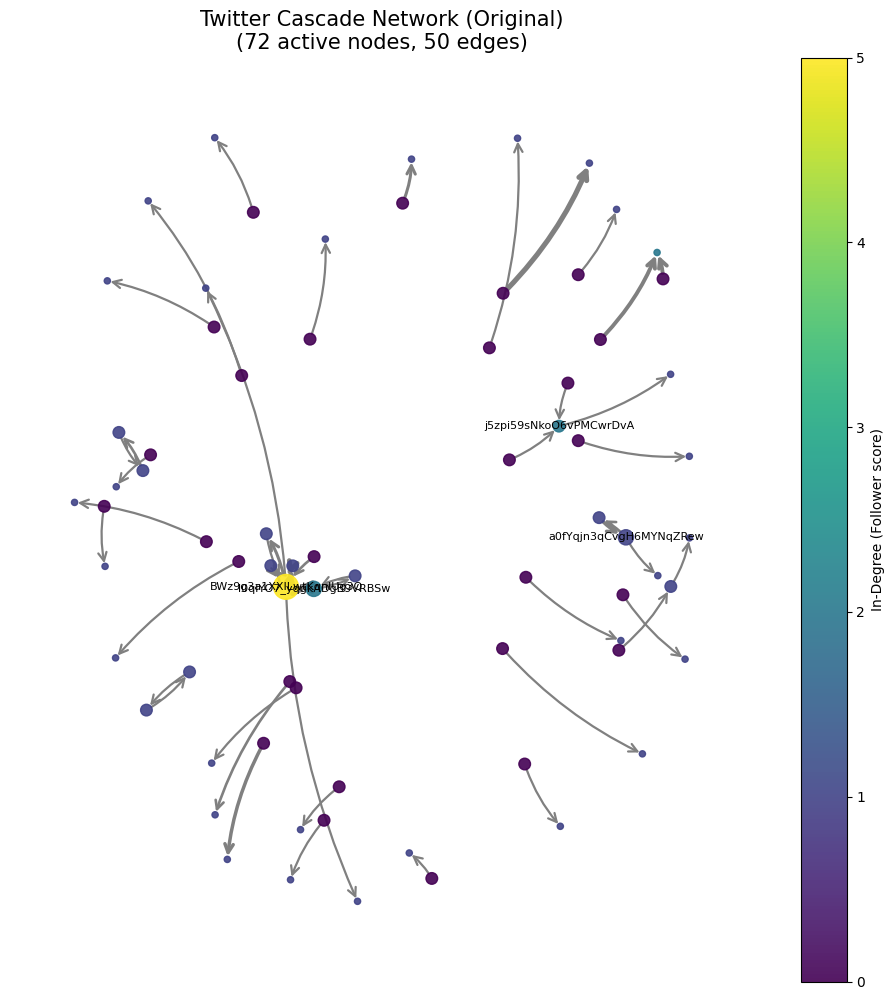

Affichage filtré (poids >= 2). Arêtes restantes : 19


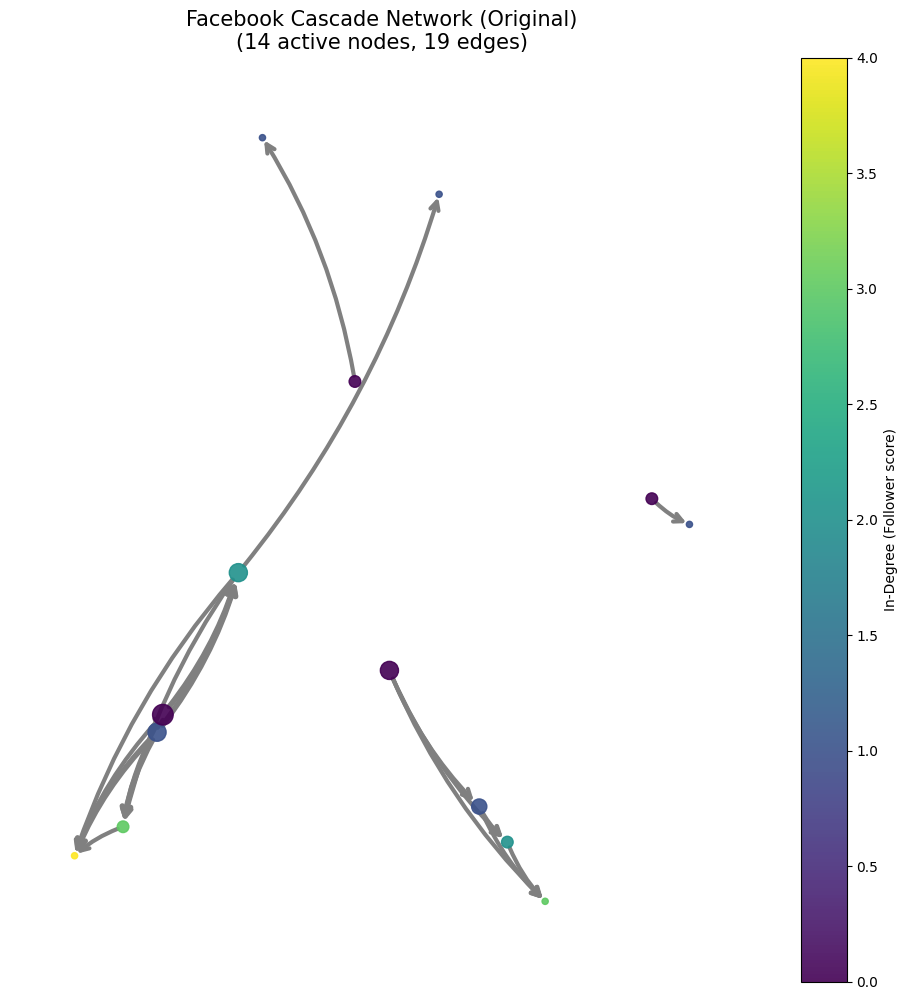

In [7]:
import numpy as np

def extract_cascade_network(df, time_threshold=52):
    """
    Génère un graphe dirigé (Cascade).
    Si User A poste à t, et User B poste la même vidéo à t+delta (delta < threshold),
    alors on crée une flèche A -> B.
    Les arêtes sont pondérées par le nombre d'occurrences.
    """
    print("Extraction du réseau de cascade (Dirigé)...")
    G = nx.DiGraph()
    
    # Préparation
    df['nodeTime'] = pd.to_datetime(df['nodeTime'])
    all_users = df['nodeUserID'].unique()
    G.add_nodes_from(all_users)
    
    grouped = df.groupby('videoID')
    
    # Dictionnaire pour compter les poids des arêtes : (source, target) -> count
    edge_weights = {}
    
    for video_id, group in grouped:
        if len(group) < 2:
            continue
            
        group = group.sort_values('nodeTime')
        users = group['nodeUserID'].tolist()
        times = group['nodeTime'].tolist()
        n = len(users)
        
        for i in range(n):
            for j in range(i + 1, n):
                delta = (times[j] - times[i]).total_seconds()
                
                if delta <= time_threshold:
                    source = users[i]
                    target = users[j]
                    
                    if source != target:
                        # On compte l'interaction
                        pair = (source, target)
                        if pair in edge_weights:
                            edge_weights[pair] += 1
                        else:
                            edge_weights[pair] = 1
                else:
                    break # Optimisation fenêtre glissante
    
    # Ajout des arêtes pondérées dans le graphe
    for (source, target), weight in edge_weights.items():
        G.add_edge(source, target, weight=weight)
        
    print(f"Cascade extraite : {G.number_of_nodes()} noeuds, {G.number_of_edges()} flèches.")
    return G

def plot_cascade_network(G, title="Cascade Network", min_weight=1):
    """
    Affiche le graphe de cascade.
    - Taille des noeuds proportionnelle au Out-Degree (Influenceurs).
    - Epaisseur des liens proportionnelle au Poids.
    - Filtre les liens faibles si min_weight > 1.
    """
    plt.figure(figsize=(12, 12))
    
    # 1. Filtrage (Optionnel : pour y voir plus clair)
    if min_weight > 1:
        edges_to_keep = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= min_weight]
        G_sub = G.edge_subgraph(edges_to_keep)
        # On garde quand même tous les noeuds connectés pour la structure
        print(f"Affichage filtré (poids >= {min_weight}). Arêtes restantes : {len(edges_to_keep)}")
    else:
        G_sub = G
        # On supprime les noeuds totalement isolés pour nettoyer le dessin
        G_sub = G_sub.subgraph([n for n in G_sub.nodes if G_sub.degree(n) > 0])

    if len(G_sub.nodes) == 0:
        print("Rien à afficher (graphe vide après filtrage).")
        return

    # 2. Layout (Disposition)
    # spring_layout est bon pour visualiser les clusters
    # k contrôle l'espacement (plus k est grand, plus les noeuds s'écartent)
    pos = nx.spring_layout(G_sub, k=0.15, iterations=20, seed=42)
    
    # 3. Calcul des attributs visuels
    # Taille basée sur le Out-Degree (ceux qui initient l'action)
    d = dict(G_sub.out_degree())
    node_sizes = [v * 50 + 20 for v in d.values()] # *50 pour agrandir l'effet
    
    # Couleurs basées sur le In-Degree (ceux qui suivent) vs Out-Degree
    node_colors = [G_sub.in_degree(n) for n in G_sub.nodes()]
    
    # Largeur des flèches basée sur le poids
    weights = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
    # Normalisation pour éviter des traits trop énormes
    if weights:
        max_w = max(weights)
        width_ratios = [1 + (w / max_w * 3) for w in weights]
    else:
        width_ratios = 1

    # 4. Dessin
    nodes = nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, 
                                   node_color=node_colors, cmap=plt.cm.viridis, 
                                   alpha=0.9)
    
    edges = nx.draw_networkx_edges(G_sub, pos, node_size=node_sizes, 
                                   arrowstyle='->', arrowsize=15, 
                                   edge_color='gray', width=width_ratios, 
                                   connectionstyle='arc3,rad=0.1') # Courbure pour voir A->B et B->A
    
    # Labels (Seulement pour les gros noeuds pour ne pas surcharger)
    # On affiche l'ID si le noeud a un degré > moyenne
    avg_degree = np.mean([d for n, d in G_sub.degree()])
    labels = {n: n for n in G_sub.nodes() if G_sub.degree(n) > avg_degree * 2}
    nx.draw_networkx_labels(G_sub, pos, labels=labels, font_size=8, font_color='black')

    plt.title(f"{title}\n({G_sub.number_of_nodes()} active nodes, {G_sub.number_of_edges()} edges)", fontsize=15)
    plt.colorbar(nodes, label="In-Degree (Follower score)")
    plt.axis('off')
    plt.show()

def inspect_top_influencer(G, specific_node_id=None):
    """
    Isole et affiche le voisinage du noeud le plus important (ou d'un noeud spécifique).
    Affiche les poids sur les flèches pour comprendre l'intensité des liens.
    """
    # 1. Trouver le noeud cible
    if specific_node_id is None:
        # On cherche le noeud avec le plus gros Out-Degree (le plus influent)
        # Si le graphe n'est pas dirigé, on prend le Degree tout court
        if G.is_directed():
            degrees = dict(G.out_degree())
        else:
            degrees = dict(G.degree())
            
        target_node = max(degrees, key=degrees.get)
        print(f"Zoom sur le noeud le plus actif : {target_node} ({degrees[target_node]} connexions)")
    else:
        target_node = specific_node_id

    # 2. Extraire le 'Ego Graph' (Le noeud + ses voisins directs)
    # radius=1 signifie "juste les amis directs". radius=2 inclurait les "amis d'amis".
    ego_G = nx.ego_graph(G, target_node, radius=1)
    
    if len(ego_G) < 2:
        print("Ce noeud est isolé ou n'a pas de voisins.")
        return

    # 3. Affichage 'Zoomé'
    plt.figure(figsize=(10, 8))
    
    # Disposition en étoile (le chef au centre)
    pos = nx.spring_layout(ego_G, k=0.5, seed=42) 
    
    # Dessiner les noeuds
    # Le centre en ROUGE, les voisins en BLEU
    node_colors = ['red' if n == target_node else 'skyblue' for n in ego_G.nodes()]
    nx.draw_networkx_nodes(ego_G, pos, node_color=node_colors, node_size=800, alpha=0.9)
    
    # Dessiner les arêtes
    nx.draw_networkx_edges(ego_G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')
    
    # Labels des noeuds (Noms des utilisateurs)
    nx.draw_networkx_labels(ego_G, pos, font_size=10, font_weight='bold')
    
    # Labels des arêtes (Les POIDS ! Très important pour voir la répétition)
    edge_labels = nx.get_edge_attributes(ego_G, 'weight')
    nx.draw_networkx_edge_labels(ego_G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title(f"Inspection locale du noeud : {target_node}", fontsize=15)
    plt.axis('off')
    plt.show()


df_twitter = pd.read_csv('original_data/twitter_cross_platform.csv', sep=',')
df_facebook = pd.read_csv('original_data/facebook_cross_platform.csv', sep=',')
    
# 1. Extraire la cascade
G_cascade_twitter = extract_cascade_network(df_twitter, time_threshold=120)
G_cascade_facebook = extract_cascade_network(df_facebook, time_threshold=120)


# 2. Afficher
# Pour Twitter, comme tu as ~250 arêtes, tu n'as pas besoin de filtrer (min_weight=1)
plot_cascade_network(G_cascade_twitter, title="Twitter Cascade Network (Original)", min_weight=2)

plot_cascade_network(G_cascade_facebook, title="Facebook Cascade Network (Original)", min_weight=2)